# CS4248 Project Notebook

In [1]:
%env PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True
%env CUDA_LAUNCH_BLOCKING=1

env: PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True
env: CUDA_LAUNCH_BLOCKING=1


In [2]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import torch
from torch import nn, tensor, zeros, argmax, arange
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence, pad_sequence
import sentencepiece as spm
import matplotlib.pyplot as plt

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
device = torch.device("cuda")

torch.cuda.empty_cache()
print(f"Free memory: {torch.cuda.mem_get_info()[0] / 1024**3:.2f} GB \nTotal Available: {torch.cuda.mem_get_info()[1] / 1024**3:.2f} GB")

Free memory: 17.58 GB 
Total Available: 39.38 GB


In [3]:
column_names = ['category', 'text']

train = pd.read_csv('shuffletrain.csv', names=column_names)
X_train = train['text']
y_train = train['category']
y_train = y_train.astype('int16')

#! use 1/10 of the training data
X_train = X_train[:len(X_train)//10]
y_train = tensor(y_train)[:len(y_train)//10].type(torch.long)-1

test = pd.read_csv('balancedtest.csv', names=column_names)

In [4]:
# CONSTANTS

# HYPERPARAMETERS
vocab_size = 5_000
# Generator
global_batch_size = 64  # Batch size
embed_dim = 512  # Dimensionality of word embeddings
hidden_dim = 256  # Number of features in the hidden state of the LSTM
enc_drop = 0.2  # Dropout rate for the encoder LSTM
dec_drop = 0.2  # Dropout rate for the decoder LSTM
temperature = 1 # Temperature for sampling
word_limit = 512  # Maximum number of words to generate TODO: for first batch only
lr_gen_optim = 10  # Learning rate for generator optimizer

# Discriminator1
lstm_hidden_dim = 64  # Number of features in the hidden state of the LSTM
dense_dim = 32  # Number of features in the dense layer
dropout_prob = 0.2  # Dropout rate
lr_disc1_optim = 0.000005  # Learning rate for discriminator1 optimizer

# Cooperator
coop_embed_dim = 512
coop_hidden_dim = 256
coop_dropout = 0.2
coop_lr = 0.0001

# Discriminator 2
disc2_embed_dim = 256
disc2_hidden_dim = 128
disc2_dropout = 0.4
disc2_lr = 0.0001

epochs = 25  # Number of epochs

## Preprocessing
#### Current
We make use of `SentencePieceTrainer` to train a SentencePiece model on all of the training data. We then use this model to tokenize the data. We set a vocabulary size of 8000

In [5]:
# Used to extract the text from the CSV file

# # Path to your CSV file
# csv_file_path = 'fulltrain.csv'
# # Path to the output text file
# text_file_path = 'fulltrain_textonly.txt'

# # Load the CSV file
# df = pd.read_csv(csv_file_path, names=column_names)

# # Assuming the text column is named 'text'. Adjust if your column name is different
# texts = df['text']

# # Save the text column to a plain text file
# with open(text_file_path, 'w', encoding='utf-8') as f:
#     for text in texts:
#         f.write(text + '\n')




In [6]:
# Used to create the SentencePiece model and save it to a file
# We only need to run this once to create the model file

# spm.SentencePieceTrainer.train(input="fulltrain_textonly.txt", 
#                                model_prefix='spm_noembedding', 
#                                vocab_size=vocab_size, 
#                                max_sentence_length=100_000,
#                                unk_id=0, bos_id=1, eos_id=2, pad_id=3)



## Generator

In [7]:
class Generator(nn.Module):
    def __init__(self, vocabulary_size, embed_dim, hidden_dim, enc_drop, dec_drop, temperature, word_limit, eot_index, padding_index, bos_index):
        super(Generator, self).__init__()
        self.vocabulary_size = vocabulary_size
        self.embed_dim = embed_dim
        self.hidden_dim = hidden_dim
        self.enc_drop = enc_drop
        self.dec_drop = dec_drop
        self.temperature = temperature
        self.word_limit = word_limit
        self.eot_index = eot_index
        self.padding_index = padding_index
        self.bos_index = bos_index
        
        # Encoder
        self.encode = nn.Sequential(
            nn.Embedding(vocabulary_size, embed_dim, padding_idx=padding_index),
            nn.LSTM(embed_dim, hidden_dim, batch_first=True, dropout=enc_drop)
        )

        self.transform_hidden = nn.Linear(hidden_dim, hidden_dim * 4)
        self.transform_cell = nn.Linear(hidden_dim, hidden_dim * 4)
        
        # Decoder setup
        self.dec_embed = nn.Linear(vocabulary_size, embed_dim)
        self.dec_lstm = nn.LSTM(embed_dim, hidden_dim, dropout=dec_drop, batch_first=True)
        self.dec_softmax = nn.Sequential(
            nn.Linear(hidden_dim, vocabulary_size),
            nn.Softmax(dim=-1)
        )
    
    def forward(self, batch_indexes, batch_target_class, max_len=word_limit):
        batch_size = batch_indexes.size(0)
        # encode the input sequence
        _, (hn, cn) = self.encode(batch_indexes) # 1 * batch_size * hidden_dim

        # transform the hidden and cell state to the respective target class
        hn = self.transform_hidden(hn).reshape((batch_size, 4, hidden_dim))[arange(batch_size), batch_target_class].unsqueeze(0)
        cn = self.transform_cell(cn).reshape((batch_size, 4, hidden_dim))[arange(batch_size), batch_target_class].unsqueeze(0)

        # Samples hold the generated sequences
        samples = zeros((max_len, batch_size, vocab_size)).to(device)
        samples[0, :, self.bos_index] = 1 # set the first token to the BOS token

        # Distribution: We initialise all to 0 except the BOS token
        with torch.no_grad():
            dist = torch.zeros(batch_size, vocab_size).to(device) # batch_size * vocab_size
            dist[:, self.bos_index] = 1

        for i in range(1, max_len): # Start from 1 because we have already set the first token
            # Generate next word
            word_tensor = self.dec_embed(dist).to(device) # batch_size * embed_dim
            _ , (hn, cn) = self.dec_lstm(word_tensor.unsqueeze(1), (hn, cn)) # batch_size * 1 * embed_dim, batch_size * hidden_dim
            # del word_tensor
            dist = self.dec_softmax(hn.squeeze(0)) # batch_size * vocab_size
            samples[i] = dist
        
        return samples.permute(1, 0, 2)

## Discriminator 1

In [8]:
import torch
import torch.nn as nn

class Discriminator1(nn.Module):
    def __init__(self, vocabulary_size, embedding_dim, hidden_dim, padding_index):
        super(Discriminator1, self).__init__()
        self.embedding = nn.Linear(vocabulary_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.embedding(x)  # Shape: [batch_size, seq_length, embedding_dim]
        
        _, (hn, _) = self.lstm(x)  # hn shape: [1, batch_size, hidden_dim] for 1 layer LSTM
        
        hn = hn[0]  # Shape: [batch_size, hidden_dim]
        
        x = self.linear(hn)  # Shape: [batch_size, 1]
        x = x.squeeze(-1)
        x = self.sigmoid(x)
        return x


## Generator-Discriminator 1 Integration

In [9]:
sp = spm.SentencePieceProcessor(model_file='spm_noembedding.model')

eot_index = sp.eos_id()
pad_index = sp.pad_id()
bos_index = sp.bos_id()
tokens = [sp.encode(text, out_type=int, add_bos=True, add_eos=True)[:1000] for text in X_train]
tokens = [torch.tensor(token, dtype=int).flip(-1) for token in tokens]
padded = nn.utils.rnn.pad_sequence(tokens, batch_first=True, padding_value=pad_index).flip(-1)  # num_seq * max_seq

# permutation = torch.randperm(len(padded))
# padded = padded[permutation]
# y_train = y_train[permutation]

In [10]:
import torch.optim as optim
from torch.nn import BCELoss
from torch import ones_like, zeros_like, tensor
from tqdm import tqdm

bce = BCELoss()

generator = Generator(vocab_size, embed_dim, hidden_dim, enc_drop, dec_drop, temperature, word_limit, eot_index, pad_index, bos_index).to(device)
discriminator1 = Discriminator1(vocab_size, embed_dim, hidden_dim, pad_index).to(device)
generator_optimizer = optim.Adam(generator.parameters(), lr=lr_gen_optim)
discriminator1_optimizer = optim.Adam(discriminator1.parameters(), lr=lr_disc1_optim)

/home/j/jonasg/.local/lib/python3.10/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


## Cooperator

In [11]:
class Cooperator(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, dropout):
        super(Cooperator, self).__init__()
        self.embedding = nn.Linear(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True, dropout=dropout)
        self.linear = nn.Linear(hidden_dim, 4)
        self.softmax = nn.Softmax(dim=-1)
    def forward(self, x):
        x = self.embedding(x)
        _ , (hn, _) = self.lstm(x)
        x = self.linear(hn[0])
        x = self.softmax(x)
        return x

## Discriminator 2

In [12]:
class Discriminator2(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, dropout):
        super(Discriminator2, self).__init__()
        self.embedding = nn.Linear(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True, dropout=dropout)
        self.linear = nn.Linear(hidden_dim, 4)
        self.softmax = nn.Softmax(dim=-1)
    def forward(self, x):
        x = self.embedding(x)
        _ , (hn, _) = self.lstm(x)
        x = self.linear(hn[0])
        x = self.softmax(x)
        return x

In [13]:
def index_to_binary(batch_indexes):
    batch_size, seq_size = batch_indexes.shape
    batch_binary = zeros((batch_size, seq_size, vocab_size)).to(device)
    batch_binary[arange(batch_size)[:, None], arange(seq_size)[None, :], batch_indexes] = 1
    return batch_binary

## Complete Integration

In [14]:
from torch import optim, nn, randint, cat, zeros, ones

cooperator = Cooperator(vocab_size, coop_embed_dim, coop_hidden_dim, coop_dropout).to(device)
discriminator2 = Discriminator2(vocab_size, disc2_embed_dim, disc2_hidden_dim, disc2_dropout).to(device)
cooperator_optim = optim.Adam(cooperator.parameters(), lr=coop_lr)
discriminator2_optim = optim.Adam(discriminator2.parameters(), lr=disc2_lr)

CELoss = nn.CrossEntropyLoss()

/home/j/jonasg/.local/lib/python3.10/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/home/j/jonasg/.local/lib/python3.10/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [15]:
gen_losses = []
disc1_losses = []
coop_losses = []
disc2_losses = []

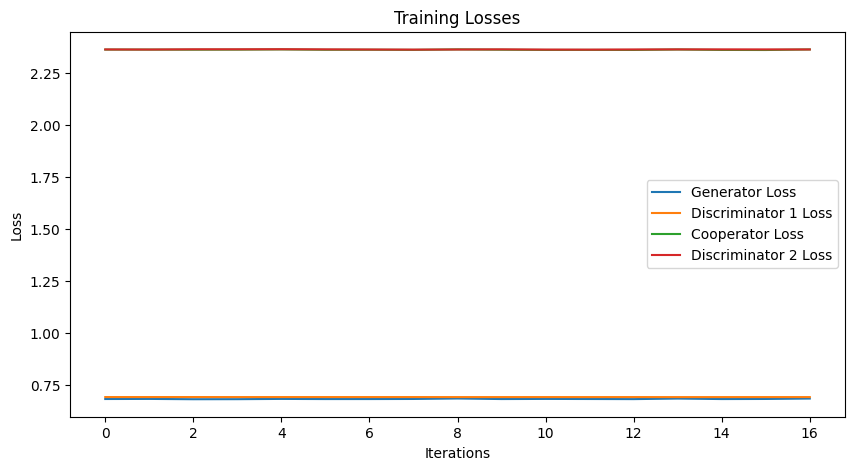

Training:   8%|████████████▎                                                                                                                                                 | 6/77 [00:06<01:11,  1.00s/it]

Free memory: 0.22 GB 
Total Available: 39.38 GB


KeyboardInterrupt: 

In [19]:
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    for i in tqdm(range(0, len(padded), global_batch_size), desc='Training', leave=False):
        print(f"Free memory: {torch.cuda.mem_get_info()[0] / 1024**3:.2f} GB \nTotal Available: {torch.cuda.mem_get_info()[1] / 1024**3:.2f} GB")
        
        batch_size = min(global_batch_size, len(padded) - i)
        batch_indexes = padded[i:i+batch_size].to(device)  # Get a batch of sequences batch_size * max_seq
        batch_human_class = tensor(y_train)[i:i+batch_size].type(torch.long).to(device)
        batch_target_class = randint(4, (batch_size, )).to(device)
        modified_human = index_to_binary(batch_indexes)

        gen_batch = generator(batch_indexes, batch_target_class)
        disc1_AI = discriminator1(gen_batch)
        coop_AI = cooperator(gen_batch)
        disc2_AI = discriminator2(gen_batch)

        disc1_human = discriminator1(modified_human)
        coop_human = cooperator(modified_human)
        disc2_human = discriminator2(modified_human)

        zero_tensor = zeros(batch_size).to(device)
        one_tensor = ones(batch_size).to(device)
        disc1_loss = bce(cat((disc1_AI, disc1_human)), cat((zero_tensor, one_tensor)))
        disc1_losses.append(disc1_loss.detach().cpu())

        with torch.no_grad():
            disc1_AI_loss = bce(disc1_AI, zero_tensor)
            coop_AI_loss = CELoss(coop_AI, batch_target_class)
            disc2_AI_loss = CELoss(disc2_AI, batch_target_class)

        gen_loss = bce(disc1_AI, one_tensor) + coop_AI_loss - disc2_AI_loss
        gen_losses.append(gen_loss.detach().cpu())
        coop_loss = disc1_AI_loss * coop_AI_loss + CELoss(coop_human, batch_human_class)
        coop_losses.append(coop_loss.detach().cpu())
        disc2_loss = disc1_AI_loss * disc2_AI_loss + CELoss(disc2_human, batch_human_class)
        disc2_losses.append(disc2_loss.detach().cpu())

        print("GEN {} DISC1 {} COOP {} DISC2 {}".format(gen_loss, disc1_loss, coop_loss, disc2_loss))
        # print(coop_human.argmax(dim=-1))
        # print(batch_human_class)
        # print(disc1_AI)
        # print(bce(disc1_AI, one_tensor))

        # generator_optimizer.zero_grad()
        # gen_loss.backward(retain_graph=True)
        # # for weight in generator.parameters():
        # #     print(weight.grad)
        # generator_optimizer.step()

        # discriminator1_optimizer.zero_grad()
        # disc1_loss.backward()
        # # for weight in discriminator1.parameters():
        # #     print(weight.grad)
        # discriminator1_optimizer.step()

        # cooperator_optim.zero_grad()
        # coop_loss.backward()
        # # for weight in cooperator.parameters():
        # #     print(weight.grad)
        # cooperator_optim.step()

        # discriminator2_optim.zero_grad()
        # disc2_loss.backward()
        # # for weight in discriminator2.parameters():
        # #     print(weight.grad)
        # discriminator2_optim.step()

        ######## DEBUG REGION ########
        # Display the losses every 50 iterations
        if i % 10 == 0:
            # Plot the losses
            plt.figure(figsize=(10, 5))
            plt.plot(gen_losses, label='Generator Loss')
            plt.plot(disc1_losses, label='Discriminator 1 Loss')
            plt.plot(coop_losses, label='Cooperator Loss')
            plt.plot(disc2_losses, label='Discriminator 2 Loss')
            plt.legend()
            plt.xlabel('Iterations')
            plt.ylabel('Loss')
            plt.title('Training Losses')
            
            clear_output(wait=True)
            display(plt.gcf())  # gcf - Get Current Figure
            plt.close()  # Close the figure to prevent it from being displayed again in the output
        ######## END DEBUG REGION ########

        # delete afterwards

torch.save(generator.state_dict(), "generator_test_1.pth")
torch.save(discriminator1.state_dict(), "discriminator1_test_1.pth")
torch.save(cooperator.state_dict(), "cooperator_test_1.pth")
torch.save(discriminator2.state_dict(), "discriminator2_test_1.pth")

### Test code region

In [ ]:
# generator_test = Generator(vocab_size, embed_dim, hidden_dim, enc_drop, dec_drop, temperature, word_limit, eot_index).to(device)
# discriminator1_test = Discriminator1(vocab_size, embed_dim, hidden_dim).to(device)

# generator_test.load_state_dict(torch.load("generator_test_1_small.pth"))
# generator_test.eval()

# generator_optimizer_test = optim.Adam(generator_test.parameters(), lr=lr_gen_optim)
# discriminator1_optimizer_test = optim.Adam(discriminator1_test.parameters(), lr=lr_disc1_optim)

In [ ]:
# print generated text
gen_batch = generator(padded[:3].to(device), 3)
gen_text = sp.decode([i.item() for i in gen_batch[0]])
print(gen_text)
gen_text = sp.decode([i.item() for i in gen_batch[2]])
print(gen_text)

In [ ]:
# Plot the losses

plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(generator_losses, label="Generator")
plt.plot(discriminator1_losses, label="Discriminator")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()
plt.savefig("losses.png")
plt.close()

In [ ]:
# # generate text
# test = padded[83:99].to(device)
# generated_texts = generator.generate_text(test, sequence_lengths[83:99], len(test))


In [ ]:
# for i, text in enumerate(generated_texts):
#     print(f"Generated text {i+1}:")
#     print(text[1:-1])
#     print(sp.decode([token for token in text[1:-1]]))
#     print()

In [ ]:
# import torch

# def model_memory_usage_in_MB(model):
#     # Calculate the number of elements in the model parameters
#     num_params = sum(param.numel() for param in model.parameters())
    
#     # Assuming parameters are stored as 32-bit floats (4 bytes each), calculate memory usage in bytes
#     memory_usage_bytes = num_params * 4
    
#     # Convert bytes to megabytes
#     memory_usage_MB = memory_usage_bytes / (1024 ** 2)
    
#     return memory_usage_MB

# generator_memory = model_memory_usage_in_MB(generator)
# discriminator_memory = model_memory_usage_in_MB(discriminator1)

# print(f"Generator Memory Usage: {generator_memory:.2f} MB")
# print(f"Discriminator Memory Usage: {discriminator_memory:.2f} MB")
